# CIFAR-10 classifier from nnBuilder

This is a simple implementation of a CIFAR-10 classifier using the nnBuilder framework. Trying to reproduce the network of https://www.tensorflow.org/tutorials/deep_cnn/ (Work in progress)

In [1]:
import tensorflow as tf
import numpy as np
import sys, os, seaborn, time
sys.path.append('../nnBuilder')
from nnLayer import *
from nnInput import *
from nnTrainer import *
from nnHandler import *
from _nnUtils import *

In [2]:
#Define the network
preprocessing=True #Slow
use_pipeline=False #Broken
test_split_n=10 #Avoid OOM
batch_size=128
keep_rate=.5
#Input data
data_def=dict(x=None,type="CIFAR_10")
#Preprocessing and batching networks
preprocess_layers=[]
preprocess_layers.append(dict(type="Batch_Random_Crop",shape=[24,24,3]))
preprocess_layers.append(dict(type="Batch_Random_Horizontal_Flip"))
preprocess_layers.append(dict(type="Batch_Random_Brightness"))
preprocess_layers.append(dict(type="Batch_Random_Contrast"))
if use_pipeline:
    preprocess_layers.append(dict(type="Pipeline",num_threads=8))
batch_def=dict(type="Batch_Slice",batch=batch_size,thread_safe=use_pipeline,
               out_features=preprocessing and preprocess_layers or None)
#Input without preprocessing
eval_def=dict(type="Batch_Slice",out_features=preprocessing and [dict(type="Batch_Central_Crop",shape=[24,24])] or None)
#Main network
layers=[]
if preprocessing:
    layers.append(dict(type="Batch_Whitening"))
layers.append(dict(type="Convolution",pad="SAME",window=5,stride=1,size=64,relu=True,out_features=[
              dict(type="Pool",pad="SAME",window=3,stride=2,pool_type="max"),
              dict(type="Local_Response_Norm")]))
layers.append(dict(type="Convolution",pad="SAME",window=5,stride=1,size=64,relu=True,out_features=[
              dict(type="Pool",pad="SAME",window=3,stride=2,pool_type="max"),
              dict(type="Local_Response_Norm")]))
layers.append(dict(type="Relu",size=384))
layers.append(dict(type="Relu",size=192))
layers.append(dict(type="Linear",size=10,in_features=["Dropout"]))
network_def=dict(type="Network",layers=layers)

In [3]:
#Build the network
#Training network
data=Layer(**data_def)
batch=Layer(x=data,**batch_def)
network=Layer(x=batch,**network_def)
trainer=ClassifierTrainer(network=network,optimizer="adam",finish=True)
#Evaluate on training data without preprocessing
batch_eval=Layer(x=data,batch=batch_size,**eval_def)
network_eval=network.copy(x=batch_eval,share_vars=True)
tester_eval=ClassifierTrainer(network=network_eval,optimizer="adam",finish=True,test=True)
#Testing network
data_test=Layer(**data_def,test=True)
batch_test=Layer(x=data_test,batch=10000//test_split_n,**eval_def)
network_test=network.copy(x=batch_test,share_vars=True)
tester=ClassifierTrainer(network=network_test,optimizer="adam",finish=True,test=True)

sess=SessManager(data,batch,network,trainer,batch_eval,network_eval,tester_eval,
                 data_test,batch_test,network_test,tester)
sess.start()

Starting new session


Error rate (train): 0.889063
Error rate (eval): 0.875
Error rate (test): 0.907


<IPython.core.display.Javascript object>


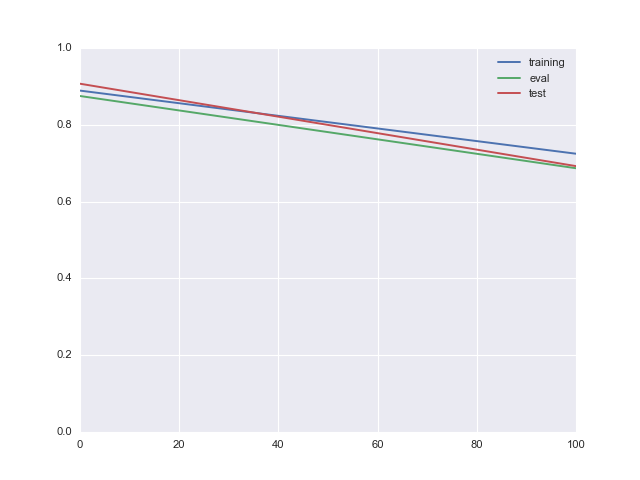

In [4]:
batches_per_step=100
batches_per_eval=100
n_steps=1
def make_plt():
    %matplotlib notebook
    global train_plot, test_plot,eval_plot, fig,ax
    fig,ax = plt.subplots(1,1)
    train_plot=ax.plot([],[], label="training")[0]
    eval_plot=ax.plot([],[], label="eval")[0]
    test_plot=ax.plot([],[], label="test")[0]
    ax.set_ylim(0,1)
    plt.legend()
    fig.canvas.draw()
    time.sleep(.01)
def update_plt():
    x=[batches_per_step*i for i in range(len(trains))]
    train_plot.set_xdata(x)
    train_plot.set_ydata(trains)
    test_plot.set_xdata(x)
    test_plot.set_ydata(tests)
    eval_plot.set_xdata(x)
    eval_plot.set_ydata(evals)
    ax.set_xlim(0,x[-1])
    fig.canvas.draw()
    #time.sleep(.01)
trainer.train(0,keep_rate=1.)
trains=[trainer.eval_error()[1]]#Initial Error rate
evals=[tester_eval.eval_error(info="eval")[1]]#Initial Error rate
tests=[tester.eval_error()[1]]
make_plt()
for i in range(n_steps):
    trainer.train(batches_per_step,keep_rate=keep_rate)
    trainer.train(0,keep_rate=1.)#To eval without dropout, fix needed
    trains.append(trainer.eval_error(n=batches_per_eval,print_=False)[1]) #Training error (with preprocessing)
    evals.append(tester_eval.eval_error(n=batches_per_eval,print_=False)[1]) #Training error (without preprocessing)
    tests.append(tester.eval_error(n=test_split_n,print_=False)[1]) #Testing error
    update_plt()

In [6]:
network.save() #The full network definition
save=network.save() #The full network definition
assert(Layer(x=batch,**save).save()==save) #Consistency
print(save==network_def) #Saving adds stuff, should still be equivalent
save

False


{'layers': [{'type': 'Batch_Whitening'},
  {'input_channels': None,
   'out_features': [{'pad': 'SAME',
     'pool_type': 'max',
     'stride': 2,
     'type': 'Pool',
     'window': 3},
    {'type': 'Local_Response_Norm'}],
   'pad': 'SAME',
   'rand_scale': 0.1,
   'relu': True,
   'size': 64,
   'stride': 1,
   'type': 'Convolution',
   'window': 5},
  {'input_channels': None,
   'out_features': [{'pad': 'SAME',
     'pool_type': 'max',
     'stride': 2,
     'type': 'Pool',
     'window': 3},
    {'type': 'Local_Response_Norm'}],
   'pad': 'SAME',
   'rand_scale': 0.1,
   'relu': True,
   'size': 64,
   'stride': 1,
   'type': 'Convolution',
   'window': 5},
  {'rand_scale': 0.1, 'size': 384, 'type': 'Relu'},
  {'rand_scale': 0.1, 'size': 192, 'type': 'Relu'},
  {'in_features': [{'type': 'Dropout'}],
   'rand_scale': 0.1,
   'size': 10,
   'type': 'Linear'}],
 'type': 'Network'}